# Metadata Quality Assessment with LLM

This notebook provides an example of how to use a large language model (LLM) to assess the quality of metadata. The method leverages a set of expert-curated guidelines to assess the quality of metadata. The LLM is tasked to assess the quality of metadata based on the guidelines and provide a revision of the metadata. Each dimension of the guidelines is assessed separately and the LLM is instructed to analyze the metadata against the guidelines for each dimension. The LLM also rates the current metadata against the guidelines.

We use the OpenAI API for the LLM.


In [1]:
%%capture

cd ~/WBG/ai4data-360/

### All module imports

In [2]:
import seaborn as sns

sns.set_theme(
    context="notebook",        # or "paper", "notebook", "poster"
    style="white",
    palette="deep",
    font_scale=1
)

In [3]:
# Standard library imports
import glob
import json
import os
import re
import pytz
from datetime import datetime, timezone
from hashlib import md5

# Third-party imports
import pandas as pd
from tqdm.auto import tqdm

/home/jupyter-wb536061/WBG/ai4data-360/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Constants
REQUIRED_COLS = ["name", "definition_long", "methodology", "license", "sources"]
VERTICALS = set(["Digital", "Infrastructure", "People", "Planet", "Prosperity"])

### Setting up directories

In [5]:
CWD = os.path.abspath("./")
assert CWD.endswith("/ai4data-360")

DATA_DIR = os.path.join(CWD, "data")

OPENAI_SAVE_DIR = os.path.join(DATA_DIR, "openai-payloads")
BATCH_SAVE_DIR = os.path.join(OPENAI_SAVE_DIR, "quality-assessment")

QUALITY_DATA_DIR = os.path.join(DATA_DIR, "quality")

os.makedirs(QUALITY_DATA_DIR, exist_ok=True)
os.makedirs(BATCH_SAVE_DIR, exist_ok=True)

### Loading external sources

In [6]:
# Load the metadata source
# Select the most recent data file
METADATA_FNAME = sorted(glob.glob(os.path.join(DATA_DIR, "data360-indicator-*.json")), key=os.path.getmtime, reverse=True)[0]
print(f"Loading file: {METADATA_FNAME}")

df = pd.read_json(METADATA_FNAME).T
df = df["series_description"].apply(pd.Series)
df.rename(columns={"idno": "indicator_code"}, inplace=True)

# Add a simple completion measure.
df["completion"] = df[REQUIRED_COLS].notnull().sum(axis=1)

# Sort the indicators based on completion, then drop any duplicated indicator code.
df = df.sort_values("completion", ascending=False).drop_duplicates(subset=["indicator_code"])

# Create the verticals
df["verticals"] = df.apply(lambda x: ";".join(sorted([i["name"] for i in x["topics"] if i["name"] in VERTICALS])), axis=1)
df.loc[df["verticals"] == "", "verticals"] = "N/A"

# Set the code as the index for content mapping below.
df.set_index("indicator_code", inplace=True)

df

Loading file: /home/jupyter-wb536061/WBG/ai4data-360/data/data360-indicator-20250403.json


,name,database_id,database_name,measurement_unit,periodicity,definition_short,definition_long,methodology,economies_count,csv_link,indicator_count,version_statement,topics,time_periods,ref_country,license,links,sources,completion,verticals
indicator_code,,,,,,,,,,,,,,,,,,,,
WB_WDI_SH_XPD_GHED_GD_ZS,Domestic general government health expenditure...,WB_WDI,World Development Indicators,None,Annual,None,Public expenditure on health from domestic sou...,The health expenditure estimates have been pre...,None,https://data360files.worldbank.org/data360-dat...,None,{'version_date': '2025-01-27'},"[{'id': None, 'name': 'Health: Health systems'...","[{'start': '2000', 'end': '2021', 'notes': None}]","[{'name': 'Afghanistan', 'code': 'AFG'}, {'nam...","[{'name': 'CC BY-4.0', 'uri': 'https://creativ...","[{'type': 'WDI API', 'description': 'Data in J...","[{'idno': None, 'type': None, 'name': 'World H...",5,People
WB_WDI_SH_XPD_PVTD_PP_CD,Domestic private health expenditure per capita...,WB_WDI,World Development Indicators,None,Annual,None,Current private expenditures on health per cap...,The health expenditure estimates have been pre...,None,https://data360files.worldbank.org/data360-dat...,None,{'version_date': '2025-01-27'},"[{'id': None, 'name': 'Health: Health systems'...","[{'start': '2000', 'end': '2021', 'notes': None}]","[{'name': 'Afghanistan', 'code': 'AFG'}, {'nam...","[{'name': 'CC BY-4.0', 'uri': 'https://creativ...","[{'type': 'WDI API', 'description': 'Data in J...","[{'idno': None, 'type': None, 'name': 'World H...",5,N/A
WB_WDI_SI_POV_LMIC_GP,Poverty gap at $3.65 a day (2017 PPP) (%),WB_WDI,World Development Indicators,%,Annual,None,Poverty gap at $3.65 a day (2017 PPP) is the m...,International comparisons of poverty estimates...,None,https://data360files.worldbank.org/data360-dat...,None,{'version_date': '2025-01-27'},"[{'id': None, 'name': 'Poverty: Poverty rates'...","[{'start': '1963', 'end': '2022', 'notes': None}]","[{'name': 'Angola', 'code': 'AGO'}, {'name': '...","[{'name': 'CC BY-4.0', 'uri': 'https://creativ...","[{'type': 'WDI API', 'description': 'Data in J...","[{'idno': None, 'type': None, 'name': 'World B...",5,N/A
WB_WDI_SI_SPR_PC40,"Survey mean consumption or income per capita, ...",WB_WDI,World Development Indicators,2017 PPP $,Annual,"Survey mean consumption or income per capita, ...",Mean consumption or income per capita (2017 PP...,"Survey mean consumption or income per capita, ...",None,https://data360files.worldbank.org/data360-dat...,None,{'version_date': '2025-01-27'},"[{'id': None, 'name': 'Poverty: Shared prosper...","[{'start': '2003', 'end': '2022', 'notes': None}]","[{'name': 'Albania', 'code': 'ALB'}, {'name': ...","[{'name': 'CC BY-4.0', 'uri': 'https://creativ...","[{'type': 'WDI API', 'description': 'Data in J...","[{'idno': None, 'type': None, 'name': 'World B...",5,N/A
WB_WDI_SL_AGR_EMPL_MA_ZS,"Employment in agriculture, male (% of male emp...",WB_WDI,World Development Indicators,% of male employment,Annual,None,Employment is defined as persons of working ag...,"The series is part of the ""ILO modeled estimat...",None,https://data360files.worldbank.org/data360-dat...,None,{'version_date': '2025-01-27'},"[{'id': None, 'name': 'Social Protection & Lab...","[{'start': '1991', 'end': '2021', 'notes': None}]","[{'name': 'Afghanistan', 'code': 'AFG'}, {'nam...","[{'name': 'CC BY-4.0', 'uri': 'https://creativ...","[{'type': 'WDI API', 'description': 'Data in J...","[{'idno': None, 'type': 'external database', '...",5,Planet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IMF_GFSR_W1_S13_G13,Government grants revenue from foreign govts,IMF_GFSR,None,"National currency, Percentage of GDP",Annual,None,None,None,None,https://data360files.worldbank.org/data360-dat...,None,{'version_date': '2025-02'},"[{'id': 'P3', 'name': 'Prosperity', 'parent_id...","[{'start': '1972', 'end': '2023', 'notes': None}]","[{'name': 'Angola', 'code': 'AGO'}, {'name': '...",[],[],"[

In [35]:
# Some simple checks of missingness and duplicates
print("Indicator name is the same as definition:", (df["name"] == df["definition_long"]).sum())
print("Indicator name is missing:", df["definition_long"].isnull().sum())
print("Indicator name is duplicated:", df["definition_long"].dropna().duplicated().sum())

Indicator name is the same as definition: 2027
Indicator name is missing: 2818
Indicator name is duplicated: 1782


### Guidelines and Prompts

#### System prompt

In [8]:
SYSTEM_PROMPT = """You are an expert in documenting development data. You are provided with a guideline for a specific metadata field and relevant information, and your task is to evaluate whether the given metadata complies with the guideline.

For each line in the guideline, assess whether the metadata meets the specified requirement. Provide your assessment within <analysis> tags, clearly explaining whether the criterion is satisfied and why. Rate the compliance on a scale from 0 to 10 for each criterion, placing the rating within <rating> tags.

Based on your analysis, propose an improved version of the metadata. Place your suggestion within <revised> tags. You must also provide an informative reason that highlights the key improvements made in the revision.

Compare the original and revised versions carefully, and identify any key information that was removed or added in the revised version. For each piece of information removed, explain why it is unnecessary or unhelpful. If a piece of information is added, explain why its addition is important. Place these information in the <modifications> tags.

The output must be in JSON with the following structure:

```json
{
  "analysis": [
    {"id": "<id>", "analysis": "<id-level analysis>", "rating": <0-10>}, ...
  ],
  "revised": "<revised>",
  "revision_reason": "<explanation why the revised version is better>",
  "modifications": [
    {
      "source": "<snippet that was removed/added>",
      "reason": "<reason why the information was removed/added from the original value>"
      "action": "<add/remove>"
    }
  ]
}```"""

#### Definition

In [9]:
DEFINITION_GUIDELINES = """# Guidelines for Writing an Indicator Definition

Each indicator definition must follow the criteria below. The purpose is to ensure that definitions are **clear**, **accessible**, **accurate**, and **scoped appropriately**, without duplicating content from other parts of the reference metadata.

---

## [id:meaning] Conceptual Clarity

Focus on what the indicator fundamentally measures.

- Clearly state **what the indicator measures**.
- Describe the **core concept or idea** the indicator captures.
- Avoid including **unrelated information** or **secondary objectives**.

---

## [id:scope] Scope and Relevance

Define the indicator's boundaries and ensure content is appropriate to this metadata field.

- Specify **what is included and excluded**, where relevant.
- Identify any **interpretation boundaries or limitations**, where applicable.
- Avoid content that belongs in other metadata fields (e.g., methodology, statistical concepts).
- Do not **duplicate** content from other reference metadata sections.

---

## [id:audience] Plain Language for Accessibility

Write for a non-technical audience using simple and neutral language.

- Use **clear, plain language**.
- Avoid **jargon** and overly academic terminology.
- Maintain a **neutral and informative tone**.

---

## [id:grammar] Grammar and Sentence Construction

Ensure readability and grammatical correctness.

- Write in **full, complete sentences**.
- Use **correct grammar**, punctuation, and sentence structure.
- Avoid fragments or lists.

---

## [id:terminology] Technical Consistency and Standards

Ensure technical language is consistent and aligned with standards.

- Use **consistent terminology** throughout the definition.
- Align with international metadata standards (e.g., **DDI**, **SDMX**, **ISO**).
- Ensure **technical accuracy** in how the indicator is described.

---

## [id:form] Structure and Formatting

Keep the definition concise and well-structured.

- Use **1 to 3 complete sentences**.
- Keep the total length between **100 and 150 words**.
- Avoid **excessive detail**, **textbook-style narratives**, or **complex sentence structures**.

---

## [id:abbreviation] Abbreviation Clarification

Ensure acronyms and abbreviations are clearly explained.

- Spell out **any acronyms or abbreviations** the first time they appear (in either the indicator name or the definition)."""

In [10]:
INDICATOR_NAME_GUIDELINES = """# Guidelines for Naming Indicators

These conventions are intended to ensure that indicator names are **concise**, **clear**, **consistent**, and **suitable for general audiences**. A well-formed indicator name improves usability across systems and helps users understand what is being measured at a glance.

---

## [id:clarity] Clarity and Conceptual Meaning

Keep the name focused and understandable.

- Clearly convey **what is being measured**, avoiding technical jargon.
- Do not assume specialized knowledge; make names **comprehensible to non-experts**.
- Avoid vague or overly complex phrases.

Good: Nitrous oxide (N2O) emissions from Waste (Mt CO₂e)
Bad: Adequacy of unemployment benefits ALMP (% of total welfare of beneficiary households)

---

## [id:length] Conciseness and Display Limits

The name should ideally be short enough to fit on screens and in data visualizations.

- Keep names to **around 70 characters or fewer**.
- Avoid **redundant** or **repetitive** language.

Good: Account ownership at financial institution
Bad: "Account" in FINDEX database
Bad: Per capita daily gas consumption (barrels per capita per day)

---

## [id:self-contained] Self-Containment and Independence

Names should stand on their own without relying on external context.

- Avoid references to databases or internal sources.
- Do not use abbreviations or variable names as stand-ins for descriptive terms.

Good: Debt service on external debt (% of GNI)
Bad: PPG; DOD (current US$)

---

## [id:acronyms] Acronym Use

Use acronyms carefully and always provide context.

- Do not use acronyms **alone** as indicator names.
- Widely known acronyms (e.g., GDP, CO₂) are acceptable if used as **part of** the name.

Good: GDP per capita (current US$)
Bad: PPG; DOD

---

## [id:units] Units of Measure

Indicate the unit of measure clearly and consistently.

- Include the unit in the name or pull it from a separate "Unit of measure" field.
- Avoid using the unit "Count"; specify **what is being counted** (e.g., persons, vehicles).
- Include the unit even when the measure is a count, for consistency.

Good: School-aged children enrolled (number of persons)
Bad: School-aged children enrolled (count)

---

## [id:disaggregation] Disaggregation Handling

Avoid embedding disaggregations directly in the name unless necessary.

- Do **not include** dimensions (e.g., sex, age) in the base indicator name if handled separately.
- If disaggregated indicators are published separately, include the relevant dimension in the name.

Good: Children in employment, wage workers, male (% of male children...)
Bad: Children in employment (%), with separate disaggregation fields not defined

---

## [id:prefixes] Avoid Unnecessary Prefixes

Start the name with the core concept being measured.

- Avoid starting with words like "Share of", "Percentage of" unless essential.
- Emphasize **what is measured**, not how it is expressed.

Good: Population using safely managed sanitation services
Bad: Share of population using safely managed sanitation services

---

## [id:year] Reference Years

Keep reference years out of indicator names.

- Use **"reference year"** or **"constant US$"** instead of naming a specific year.
- This ensures names remain valid across data updates.

Good: Net official aid received (constant US$)
Bad: Net official aid received (constant 2021 US$)

---

## [id:capitalization] Capitalization and Style

Use consistent capitalization for all indicator names.

- Follow **title case** capitalization (capitalize major words, lowercase articles/conjunctions).
- Avoid unnecessary use of uppercase.

Good: Nitrous Oxide (N2O) Emissions from Waste (Mt CO₂e)
Bad: Nitrous oxide (N2O) emissions from Waste (Mt CO₂e)"""

In [11]:
print(f"{SYSTEM_PROMPT}\n\n{INDICATOR_NAME_GUIDELINES}")

You are an expert in documenting development data. You are provided with a guideline for a specific metadata field and relevant information, and your task is to evaluate whether the given metadata complies with the guideline.

For each line in the guideline, assess whether the metadata meets the specified requirement. Provide your assessment within <analysis> tags, clearly explaining whether the criterion is satisfied and why. Rate the compliance on a scale from 0 to 10 for each criterion, placing the rating within <rating> tags.

Based on your analysis, propose an improved version of the metadata. Place your suggestion within <revised> tags. You must also provide an informative reason that highlights the key improvements made in the revision.

Compare the original and revised versions carefully, and identify any key information that was removed or added in the revised version. For each piece of information removed, explain why it is unnecessary or unhelpful. If a piece of information 

#### Mapping of guidelines

In [12]:
# Define the guidelines mapping here
METADATA_GUIDELINES = {
    "definition_long": DEFINITION_GUIDELINES,
    "name": INDICATOR_NAME_GUIDELINES,
}

FIELD_MAPPING = {
    "definition_long": "Definition",
    "name": "Indicator name"
}

### Functions

In [13]:
def extract_ids(guidelines):
    """Extract guideline IDs from a guidelines string.

    Args:
        guidelines (str): A string containing guidelines with sections marked by [id:name] tags.

    Returns:
        list[str]: A list of extracted ID names from the guidelines.

    Example:
        >>> guidelines = "## [id:meaning] Section 1\\n## [id:scope] Section 2"
        >>> extract_ids(guidelines)
        ['meaning', 'scope']
    """
    return re.findall(r"\[id\:(.*)?\]", guidelines)


def get_response_format(guidelines):
  ids = extract_ids(guidelines)

  response_format = {
    "type": "json_schema",
    "json_schema": {
      "name": "metadata_analysis",
      "strict": True,
      "schema": {
        "type": "object",
        "properties": {
          "analysis": {
            "type": "array",
            "items": {
              "type": "object",
              "properties": {
                "id": {
                  "type": "string",
                  "enum": ids
                },
                "analysis": {
                  "type": "string"
                },
                "rating": {
                  "type": "number"
                }
              },
              "required": [
                "id",
                "analysis",
                "rating"
              ],
              "additionalProperties": False
            }
          },
          "revised": {
            "type": "string"
          },
          "revision_reason": {
            "type": "string"
          },
          "modifications": {
            "type": "array",
            "items": {
              "type": "object",
              "properties": {
                "source": {
                  "type": "string"
                },
                "reason": {
                  "type": "string"
                },
                "action": {
                  "type": "string",
                  "enum": ["add", "remove"]
                }
              },
              "required": [
                "source",
                "reason",
                "action"
              ],
              "additionalProperties": False
            }
          }
        },
        "required": [
          "analysis",
          "revised",
          "revision_reason",
          "modifications"
        ],
        "additionalProperties": False
      }
    }
  }

  return response_format


def get_system_prompt(guidelines):
    return f"{SYSTEM_PROMPT}\n\n{guidelines}"


def build_payload(content, guidelines: str, model_id: str, **api_kwargs):
    """Builds an API payload for metadata quality assessment using an LLM.

    Args:
        content (str): The metadata content to be analyzed.
        guidelines (str): The assessment guidelines containing criteria marked with [id:name] tags.
        model_id (str): The identifier for the LLM model to be used.
        **api_kwargs: Additional keyword arguments to override default API parameters.

    Returns:
        dict: A payload dictionary containing:
            - messages: List of system and user messages with the prompt and content
            - response_format: JSON schema specification for the expected response
            - model: The specified model ID
            - Additional API parameters (temperature, max_completion_tokens, etc.)

    Notes:
        Default API parameters include:
        - temperature: 0
        - max_completion_tokens: 4096
        - top_p: 1
        - frequency_penalty: 0
        - presence_penalty: 0
        - seed: 1029
    """
    response_format = get_response_format(guidelines)

    default_kwargs = dict(
        model=model_id,
        temperature=0,
        max_completion_tokens=4096,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        seed=1029,
    )

    if api_kwargs:
        default_kwargs.update(api_kwargs)

    payload = dict(
      messages=[
        {
          "role": "system",
          "content": [
            {
              "type": "text",
              "text": get_system_prompt(guidelines)
            }
          ]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": content
            }
          ]
        }
      ],
      response_format=response_format,
      **default_kwargs,
    )

    return payload


def write_payload(payload_fname, metadata_field, contents, model_id: str, overwrite: bool = False):
    """Writes API payload data for metadata quality assessment to a JSONL file.

    Args:
        payload_fname (str): Path to the output JSONL file where payloads will be written.
        metadata_field (str): The metadata field being analyzed (e.g., 'definition').
            Must be a key in the metadata_guidelines dictionary.
        contents (dict): Dictionary mapping identifier codes to metadata content strings to be analyzed.
        model_id (str): The ID of the LLM model to use for analysis.
        overwrite (bool, optional): If True, overwrites existing file. If False, raises
            ValueError if file exists. Defaults to False.

    Raises:
        ValueError: If the output file already exists and overwrite=False.

    Notes:
        - Creates a JSONL file where each line contains a JSON object with:
            - custom_id: Generated from prompt hash, identifier code, and content hash
            - method: Always "POST"
            - url: Always "/v1/chat/completions"
            - body: The complete API payload including system prompt, user content,
                   and response format specifications
        - The metadata_field must correspond to a key in the metadata_guidelines dictionary
          which contains the assessment guidelines for that field.
    """
    if os.path.exists(payload_fname) and not overwrite:
       raise ValueError(f"File {payload_fname} exists. Set `overwrite=True` to replace this.")

    assert metadata_field in payload_fname

    guidelines = METADATA_GUIDELINES[metadata_field]
    prompt_hash = md5(get_system_prompt(guidelines).encode()).hexdigest()[:8]

    with open(payload_fname, "w") as fl:
      for code, content in contents.items():
        batch_data = dict(
            custom_id=f"{prompt_hash}-{code}-{md5(content.encode()).hexdigest()}",
            method="POST",
            url="/v1/chat/completions",
            body=build_payload(content, guidelines=guidelines, model_id=model_id),
        )
        fl.write(json.dumps(batch_data) + "\n")


# def get_field_content(df: pd.DataFrame, field: str, code_field_name: str = "indicator_code", drop_empty: bool = True):

#     assert df.index.name == code_field_name

#     func = lambda x: f"Indicator name: {x['title']}\n\n{FIELD_MAPPING[field]}: {x[field]}".strip()

#     if drop_empty:
#         df = df[df[field].notna()]

#     return df.apply(func, axis=1)


def get_field_content(df: pd.DataFrame, field: str, code_field_name: str = "indicator_code", drop_empty: bool = True, title_name: str = "Indicator name"):

    if field == "name":
       return get_indicator_name_content(
          df=df, field=field, code_field_name=code_field_name, drop_empty=drop_empty, title_name=title_name,
       )
    else:
      assert df.index.name == code_field_name

      func = lambda x: f"{title_name}: {x['title']}\n\n{FIELD_MAPPING[field]}: {x[field]}".strip()

      if drop_empty:
          df = df[df[field].notna()]

      return df.apply(func, axis=1)


def get_indicator_name_content(df: pd.DataFrame, field: str, code_field_name: str = "indicator_code", drop_empty: bool = True, title_name: str = "Indicator name"):

    assert df.index.name == code_field_name

    func = lambda x: f"{FIELD_MAPPING[field]}: {x[field]}".strip()

    if drop_empty:
        df = df[df[field].notna()]

    return df.apply(func, axis=1)

In [14]:
print(str(extract_ids(INDICATOR_NAME_GUIDELINES)).replace("'", '"'))

["clarity", "length", "self-contained", "acronyms", "units", "disaggregation", "prefixes", "year", "capitalization"]


### Generate the payloads

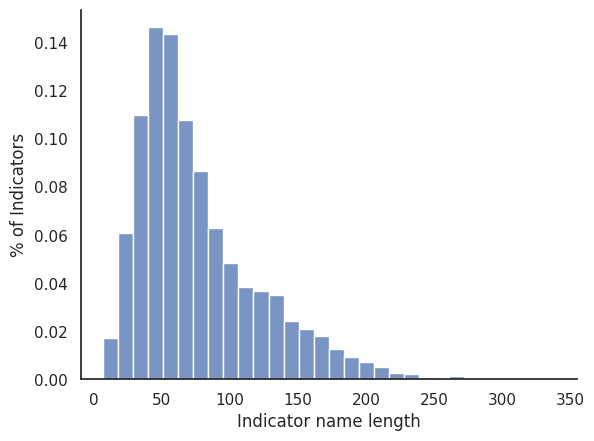

In [15]:
ax = sns.histplot(data=df["name"].map(len), stat="probability", bins=30)
ax.set_ylabel("% of Indicators")
ax.set_xlabel("Indicator name length")
sns.despine(right=True, top=True, left=False, bottom=False)

In [16]:
df["name"].map(len).describe()

count    10574.000000
mean        77.005769
std         44.259267
min          7.000000
25%         45.000000
50%         64.000000
75%         98.000000
max        338.000000
Name: name, dtype: float64

In [17]:
MODEL_ID = "gpt-4o"
code_field_name = "indicator_code"
title_name = "Indicator name"
fields = ["name"]
data_type = "indicator"

# Define the Eastern Time timezone
run_date = datetime.now(pytz.timezone('US/Eastern')).date()

for metadata_field in fields:
    payload_fname = os.path.join(BATCH_SAVE_DIR, f"{data_type}-{metadata_field}-{run_date}.input.jsonl")

    print(f"Generating payloads to: {payload_fname}")

    contents = get_field_content(df, field=metadata_field, code_field_name=code_field_name, title_name=title_name)

    write_payload(payload_fname, metadata_field, contents, model_id=MODEL_ID, overwrite=False)

Generating payloads to: /home/jupyter-wb536061/WBG/ai4data-360/data/openai-payloads/quality-assessment/indicator-name-2025-04-03.input.jsonl


In [27]:
MODEL_ID = "gpt-4o"
code_field_name = "indicator_code"
title_name = "Indicator name"
fields = ["definition_long"]
data_type = "indicator"


# Define the Eastern Time timezone
run_date = datetime.now(pytz.timezone('US/Eastern')).date()

for metadata_field in fields:
    payload_fname = os.path.join(BATCH_SAVE_DIR, f"{data_type}-{metadata_field}-{run_date}.input.jsonl")

    print(f"Generating payloads to: {payload_fname}")

    contents = get_field_content(df, field=metadata_field, code_field_name=code_field_name, title_name=title_name)

    write_payload(payload_fname, metadata_field, contents, model_id=MODEL_ID, overwrite=False)

Generating payloads to: /home/jupyter-wb536061/WBG/ai4data-360/data/openai-payloads/quality-assessment/definition_long-2025-03-27.input.jsonl


## Process output

In [17]:
import glob
from datasets import load_dataset

# base_name = "definition_long-*.output.jsonl"
base_name = "indicator-name-*.output.jsonl"

out_fnames = sorted(glob.glob(os.path.join(BATCH_SAVE_DIR, base_name)))

out_dataset = load_dataset("json", data_files=out_fnames, split="train")
out_dataset

Dataset({
    features: ['id', 'custom_id', 'response', 'error'],
    num_rows: 10574
})

In [18]:
def parse_content(content):
    content = json.loads(content)

    output = {
        "revised": content["revised"],
        "revision_reason": content["revision_reason"],
        "modifications": "",
    }

    # Flatten the data
    for item in content["analysis"]:

        output[f"{item['id']}_analysis"] = item["analysis"]
        output[f"{item['id']}_rating"] = item["rating"]

    modifications_texts = []
    for item in content["modifications"]:
        source = item["source"]
        reason = item["reason"]
        action = item["action"].title()
        text = f"{action}: {source}\nReason: {reason}"

        modifications_texts.append(text)

    if modifications_texts:
        output["modifications"] = "\n---\n".join(modifications_texts).strip()

    return output


def extract_response(examples):
    outs = {"indicator_code": [], "finish_reason": []}
    other_cols = set()

    for custom_id, response in zip(examples["custom_id"], examples["response"]):
        # Parse the indicator_code
        _, code, _ = custom_id.split("-")
        choice = response["body"]["choices"][0]
        outs["finish_reason"].append(choice["finish_reason"])

        if choice["finish_reason"] == "stop":
            content = choice["message"]["content"]

            try:
                content = parse_content(content)
            except:
                content = {}

            for k in content:
                if k not in outs:
                    outs[k] = []
                    other_cols.add(k)

                outs[k].append(content[k])
        else:
            for k in other_cols:
                outs[k].append(None)

        outs["indicator_code"].append(code)

    return outs


def aggregate_rating(examples):
    overall_rating = []

    cols = [k for k in examples if k.endswith("_rating")]
    for c_ix, k in enumerate(cols):
        for v_ix, v in enumerate(examples[k]):
            if c_ix == 0:
                overall_rating[ix]

    pass

In [19]:
response_dataset = out_dataset.map(extract_response, batched=True, remove_columns=["id", "response", "error"])
print(response_dataset)

df_resp = response_dataset.to_pandas()
df_resp

Dataset({
    features: ['custom_id', 'indicator_code', 'finish_reason', 'revised', 'revision_reason', 'modifications', 'clarity_analysis', 'clarity_rating', 'length_analysis', 'length_rating', 'self-contained_analysis', 'self-contained_rating', 'acronyms_analysis', 'acronyms_rating', 'units_analysis', 'units_rating', 'disaggregation_analysis', 'disaggregation_rating', 'prefixes_analysis', 'prefixes_rating', 'year_analysis', 'year_rating', 'capitalization_analysis', 'capitalization_rating'],
    num_rows: 10574
})


,custom_id,indicator_code,finish_reason,revised,revision_reason,modifications,clarity_analysis,clarity_rating,length_analysis,length_rating,...,units_analysis,units_rating,disaggregation_analysis,disaggregation_rating,prefixes_analysis,prefixes_rating,year_analysis,year_rating,capitalization_analysis,capitalization_rating
0,b549c5b6-WB_WDI_SH_XPD_GHED_GD_ZS-f20c7a8bd713...,WB_WDI_SH_XPD_GHED_GD_ZS,stop,Domestic General Government Health Expenditure...,<revision_reason>The revised version capitaliz...,Remove: Domestic general government health exp...,<analysis>The indicator name 'Domestic general...,10,<analysis>The name is concise and fits within ...,10,...,<analysis>The unit of measure is clearly indic...,10,<analysis>The name does not include unnecessar...,10,<analysis>The name starts with the core concep...,10,<analysis>The name does not include reference ...,10,<analysis>The name uses sentence case rather t...,8
1,b549c5b6-WB_WDI_SH_XPD_PVTD_PP_CD-65294e508a0b...,WB_WDI_SH_XPD_PVTD_PP_CD,stop,Domestic Private Health Expenditure Per Capita...,The revised version improves capitalization co...,Remove: Domestic private health expenditure pe...,The indicator name clearly conveys what is bei...,9,The name is concise and fits within the 70-cha...,10,...,The unit of measure is clearly indicated as 'c...,10,The name does not include unnecessary disaggre...,10,The name starts with the core concept being me...,10,The name uses 'current international $' instea...,10,The capitalization is consistent with title ca...,10
2,b549c5b6-WB_WDI_SI_POV_LMIC_GP-ffd6b9f3de4ee96...,WB_WDI_SI_POV_LMIC_GP,stop,Poverty Gap at $3.65 a Day (PPP) (%),The revised version removes the specific refer...,Remove: 2017\nReason: Including a specific ref...,The indicator name is clear and conveys what i...,9,The name is concise and well within the 70-cha...,10,...,The unit of measure is indicated as a percenta...,10,The name does not include unnecessary disaggre...,10,The name does not start with unnecessary prefi...,10,The reference year '2017' is included in the n...,5,The capitalization is consistent with title ca...,10
3,b549c5b6-WB_WDI_SI_SPR_PC40-cf22b3242b8604c2a1...,WB_WDI_SI_SPR_PC40,stop,"Survey Mean Consumption or Income per Capita, ...",The revised version improves clarity by using ...,Remove: 2017 PPP $ per day\nReason: The specif...,The indicator name is clear in conveying what ...,9,The name is concise and fits within the 70-cha...,10,...,The unit of measure is clearly indicated as '2...,9,The disaggregation by the bottom 40% of the po...,10,The name starts with the core concept being me...,10,The reference year '2017' is included in the n...,5,The capitalization is not consistent with titl...,6
4,b549c5b6-WB_WDI_SL_AGR_EMPL_MA_ZS-30a5bd06af55...,WB_WDI_SL_AGR_EMPL_MA_ZS,stop,Male Employment in Agriculture (% of Male Empl...,The revised version improves clarity by reorde...,Add: (modeled ILO estimate)\nReason: Reordered...,The indicator name is clear in conveying what ...,7,The name is concise and fits within the 70-cha...,10,...,The unit of measure is clearly indicated as a ...,10,The disaggregation by gender is appropriately ...,10,The name starts with the core concept 'Employm...,10,There is no reference year included in the nam...,10,The capitalization is consistent with title ca...,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10569,b549c5b6-IMF_GFSR_W1_S13_G13-de258bbca34f5508c...,IMF_GFSR_W1_S13_G13,stop,Revenue from Government Grants from Foreign Go...,The revised version improves clarity by replac...,Remove: govts\nReason: The abbreviation 'govts...,The indicator name 'Government grants revenue ...,6,The name is concise and well within the 70-cha...,10,...,The indicator name does not specify the unit o...,4,"The name does not include any disaggregation, ...",10,The name does not start with unnecessary prefi...,10,There are no reference years included in the n...,10,The capitalization is inconsi

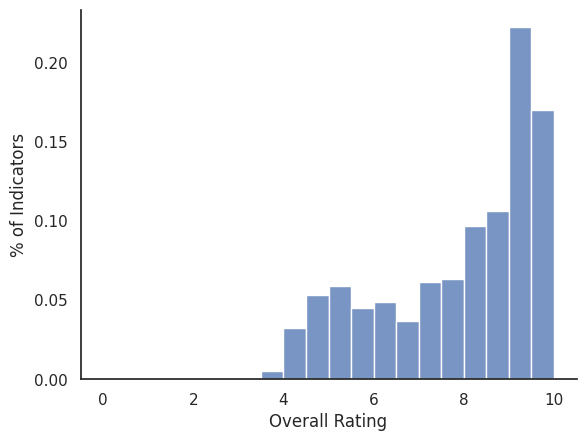

In [20]:

merged_df = df_resp.merge(df.reset_index(), how="left", on="indicator_code")
merged_df = merged_df[df.columns.tolist() + df_resp.columns.tolist()]

# Compute the mean rating of the original metadata value
merged_df["overall_rating"] = merged_df[merged_df.columns[merged_df.columns.str.endswith("_rating")]].mean(axis=1)


ax = sns.histplot(merged_df, x="overall_rating", bins=20, stat="probability", binrange=(0, 10)) # ["overall_rating"].hist()
ax.set_xlabel("Overall Rating")
ax.set_ylabel("% of Indicators")
sns.despine(right=True, top=True, left=False, bottom=False)


In [21]:
merged_df = merged_df.sort_values("overall_rating", ascending=False)
merged_df

,name,database_id,database_name,measurement_unit,periodicity,definition_short,definition_long,methodology,economies_count,csv_link,...,units_rating,disaggregation_analysis,disaggregation_rating,prefixes_analysis,prefixes_rating,year_analysis,year_rating,capitalization_analysis,capitalization_rating,overall_rating
5973,Prevalence of anemia among children (% of chil...,WB_HCP,None,% of children aged 6-59 months,None,"Prevalence of anemia (%), ages 6-59 months",Percentage of children ages 6-59 months whose ...,None,None,https://data360files.worldbank.org/data360-dat...,...,10,"The name includes disaggregation by age, which...",10,The name does not use unnecessary prefixes and...,10,"The name does not include any reference years,...",10,The capitalization is consistent with the guid...,10,10.000000
73,Oil rents (% of GDP),WB_CCDR,None,Percentage of GDP,Annual,None,Oil rents are the difference between the value...,The estimates of natural resources rents are c...,None,https://data360files.worldbank.org/data360-dat...,...,10,There is no unnecessary disaggregation embedde...,10,The name does not start with unnecessary prefi...,10,There are no reference years included in the n...,10,The capitalization is consistent with title ca...,10,10.000000
94,Rural population (% of total population),WB_CLEAR,Climate and Economic Analyses for Resilience i...,None,Annual,None,Rural population refers to people living in ru...,Rural population is calculated as the differen...,None,https://data360files.worldbank.org/data360-dat...,...,10,The name does not embed disaggregations direct...,10,The name does not start with unnecessary prefi...,10,There are no reference years included in the n...,10,The capitalization is consistent with title ca...,10,10.000000
4842,Battle-related deaths (number of people),WB_WDI,World Development Indicators,None,Annual,None,Battle-related deaths are deaths in battle-rel...,"During warfare, targets are usually the milita...",None,https://data360files.worldbank.org/data360-dat...,...,10,The name does not include any disaggregation d...,10,The name starts with the core concept being me...,10,There are no reference years included in the n...,10,"The capitalization follows title case, with ma...",10,10.000000
21,Tax revenue (% of GDP),WB_CCDR,Country Climate and Development Report,Percentage of GDP,Annual,None,Tax revenue refers to compulsory transfers to ...,The IMF's Government Finance Statistics Manual...,None,https://data360files.worldbank.org/data360-dat...,...,10,There is no unnecessary disaggregation embedde...,10,The name starts with the core concept 'Tax rev...,10,There are no reference years included in the n...,10,The capitalization is consistent with title ca...,10,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8683,"BOP, Current Account, Primary Income, Investme...",IMF_BOP,Balance of Payments (BOP) and International In...,"USD, Euros, LCU","Quarterly, Annual",None,None,None,None,https://data360files.worldbank.org/data360-dat...,...,2,The name includes multiple layers of disaggreg...,3,The name does not start with unnecessary prefi...,5,There is no reference to specific years in the...,10,"The capitalization is inconsistent, with some ...",4,3.555556
8250,"BOP, Memorandum Items, Exceptional financing, ...",IMF_BOP,Balance of Payments (BOP) and International In...,"USD, LCU, Euros","Quarterly, Annual",None,None,None,None,https://data360files.worldbank.org/data360-dat...,...,2,The name includes disaggregation details such ...,3,The name does not start with unnecessary prefi...,5,"The name does not include reference years, whi...",10,The name does not follow title case capitaliza...,4,3.555556
8614,"BOP, Memorandum Items, Exceptional financing, ...",IMF_BOP,Balance of Payments (BOP) and International In...,"USD, LCU, Euros","Quarterly, Annual",None,None,None,None,https://data360files.worldbank.org/data360-dat...,...,2,The name includes disaggregations such as 'Non...,

In [22]:
merged_df.groupby("database_id")["overall_rating"].mean().sort_values(ascending=False)

database_id
FAO_GFRA               10.000000
IMF_GENDER_EQUALITY    10.000000
WB_WWGD                 9.777778
WB_PPI                  9.641975
WB_MPM                  9.571429
                         ...    
IMF_FSI                 5.788833
IMF_IRFCL               5.566667
FAO_EMS                 5.111111
IMF_BOP                 4.989432
FAO_FBS                 4.333333
Name: overall_rating, Length: 154, dtype: float64

## Measure semantic and lexical change

In [23]:
import nltk
import numpy as np

from sentence_transformers import SentenceTransformer

st_model = SentenceTransformer("avsolatorio/GIST-small-Embedding-v0")

In [24]:
name_vecs = st_model.encode(merged_df["name"], batch_size=32, show_progress_bar=True)
revised_name_vecs = st_model.encode(merged_df["revised"], batch_size=32, show_progress_bar=True)

merged_df["semantic_change"] = (1 - np.einsum("ij,ij->i", name_vecs, revised_name_vecs)).tolist()
merged_df["lexical_change"] = merged_df.apply(lambda x: nltk.edit_distance(x["name"], x["revised"]), axis=1)

Batches: 100%|██████████| 331/331 [00:02<00:00, 124.71it/s]


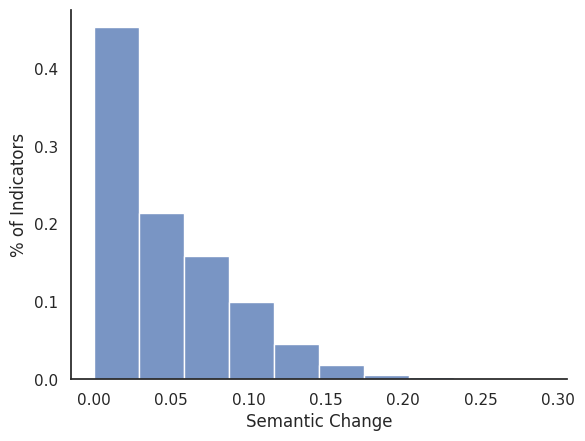

In [25]:
ax = sns.histplot(merged_df, x="semantic_change", bins=10, stat="probability") # ["overall_rating"].hist()
ax.set_xlabel("Semantic Change")
ax.set_ylabel("% of Indicators")
sns.despine(right=True, top=True, left=False, bottom=False)


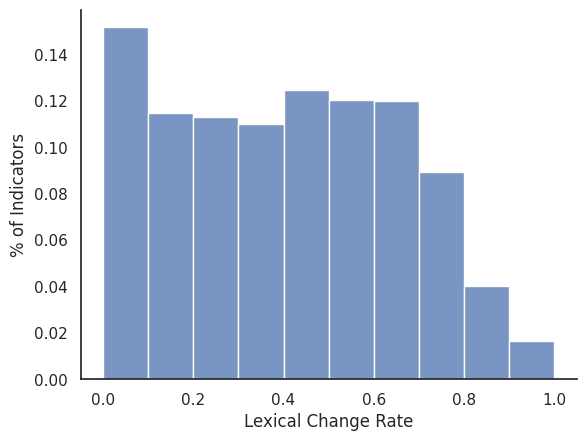

In [26]:

merged_df["lexical_change_rate"] = (merged_df["lexical_change"] / merged_df["name"].map(len))

# merged_df["lexical_change_rate"] = merged_df["lexical_change_rate"].map(lambda x: x if x < 1 else 1)

ax = sns.histplot(merged_df, x="lexical_change_rate", bins=10, binrange=(0, 1), stat="probability") # ["overall_rating"].hist()
ax.set_xlabel("Lexical Change Rate")
ax.set_ylabel("% of Indicators")
sns.despine(right=True, top=True, left=False, bottom=False)

In [28]:
merged_df.to_excel(os.path.join(QUALITY_DATA_DIR, f"assessment-indicator-name-{datetime.now().date()}.xlsx"), index=False)

In [120]:
merged_df.groupby("verticals")["overall_rating"].mean()

verticals
Digital                      8.422222
Digital;Prosperity           8.435626
Infrastructure               8.802168
Infrastructure;People        9.000000
Infrastructure;Planet        8.888889
Infrastructure;Prosperity    9.042838
N/A                          8.733778
People                       8.717756
People;Planet                8.450980
People;Prosperity            9.407407
Planet                       8.822258
Planet;Prosperity            9.065134
Prosperity                   7.189197
Name: overall_rating, dtype: float64

<Axes: >

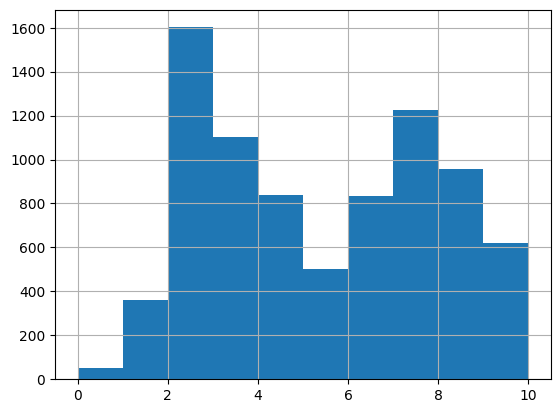

In [65]:
merged_df = df_resp.merge(df.reset_index(), how="left", on="indicator_code")
merged_df = merged_df[df.columns.tolist() + df_resp.columns.tolist()]

# Compute the mean rating of the original metadata value
merged_df["overall_rating"] = merged_df[merged_df.columns[merged_df.columns.str.endswith("_rating")]].mean(axis=1)

merged_df["overall_rating"].hist()

In [66]:
merged_df = merged_df.sort_values("overall_rating", ascending=False)
merged_df

,id,dataset,title,definition_short,definition_long,measurement_unit,sources,methodology,license,Planet,...,audience_rating,grammar_analysis,grammar_rating,terminology_analysis,terminology_rating,form_analysis,form_rating,abbreviation_analysis,abbreviation_rating,overall_rating
7886,6699,WB_EDSTATS,"Total net enrolment rate, primary, gender pari...",NaN,Ratio of female total net enrolment rate for p...,Share (proportion),"[{'name': 'Education Statistics', 'organizatio...",NaN,"[{'name': 'CC BY-4.0', 'uri': 'https://datacat...",0,...,10.0,"The definition is written in full, complete se...",10.0,The terminology is consistent throughout the d...,10.0,"The definition is concise, consisting of 3 com...",10.0,The abbreviation 'GPI' is clearly explained as...,10.0,10.0
7846,6577,WB_EDSTATS,"Gross enrolment ratio, lower secondary, gender...",NaN,Ratio of female gross enrolment ratio for lowe...,Share (proportion),"[{'name': 'Education Statistics', 'organizatio...",NaN,"[{'name': 'CC BY-4.0', 'uri': 'https://datacat...",0,...,10.0,"The definition uses full, complete sentences w...",10.0,The terminology is consistent and technically ...,10.0,"The definition is concise, consisting of three...",10.0,The abbreviation GPI is clearly explained as '...,10.0,10.0
7847,6578,WB_EDSTATS,"Gross enrolment ratio, upper secondary, gender...",NaN,Ratio of female gross enrolment ratio for uppe...,Share (proportion),"[{'name': 'Education Statistics', 'organizatio...",NaN,"[{'name': 'CC BY-4.0', 'uri': 'https://datacat...",0,...,10.0,"The definition is written in full, complete se...",10.0,The terminology is consistent and technically ...,10.0,"The definition is concise, consisting of 3 com...",10.0,The abbreviation 'GPI' is clearly explained as...,10.0,10.0
4358,6837,WB_EDSTATS,"Out-of-school rate for children, adolescents a...",NaN,"Proportion of children, adolescents, and youth...",Share (proportion),"[{'name': 'Education Statistics', 'organizatio...","To calculate the indicator, the number of stud...","[{'name': 'CC BY-4.0', 'uri': 'https://datacat...",0,...,10.0,The definition is written in a complete senten...,10.0,The terminology is consistent and technically ...,10.0,"The definition is concise, consisting of one c...",10.0,There are no acronyms or abbreviations in the ...,10.0,10.0
4338,6834,WB_EDSTATS,"Out-of-school rate for children, adolescents a...",NaN,"Proportion of children, adolescents, and youth...",Share (proportion),"[{'name': 'Education Statistics', 'organizatio...","To calculate the indicator, the number of stud...","[{'name': 'CC BY-4.0', 'uri': 'https://datacat...",0,...,10.0,The definition is written in a complete senten...,10.0,The terminology is consistent and technically ...,10.0,"The definition is concise, consisting of a sin...",10.0,There are no acronyms or abbreviations in the ...,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4813,10554,OECD_MSTI,Civil GERD,NaN,Civil GERD,% of GDP,[{'name': 'Main Science and Technology Indicat...,https://www.oecd.org/sti/inno/MSTI_documentati...,"[{'name': 'License Specified Externally', 'uri...",0,...,0.0,The definition is not a complete sentence and ...,0.0,"The definition does not use any terminology, c...",0.0,The definition is not concise or well-structur...,0.0,The definition does not spell out the acronym ...,0.0,0.0
1538,5972,WEF_TTDI,T&T GDP multiplier,T&T GDP multiplier,T&T GDP multiplier,Number,[{'name': 'Travel & Tourism Development Index ...,https://www.weforum.org/reports/travel-and-tou...,"[{'name': 'CC BY-NC-ND', 'uri': 'https://creat...",0,...,0.0,The definition is not a complete sentence and ...,0.0,The definition does not use any technical lang...,0.0,The definition is not concise or well-structur...,0.0,The definition does not spell out the acronym ...,0.0,0.0
873,11785,WEF_GCI,GCI 4.0: Railroad,GCI 4.0: Railroad,GCI 4.0: Railroad,"Rank, 0-100 scale",[{'name': 'WEF Global Competitiveness Index 4....,Of the 98 indicators 

In [67]:
(merged_df["definition_long"] == merged_df["revised"]).sum()

np.int64(0)

In [68]:
print(merged_df["revised"].iloc[1])

The Gross Enrolment Ratio, Lower Secondary, Gender Parity Index (GPI) measures the ratio of female to male gross enrolment ratios in lower secondary education. It is calculated by dividing the female gross enrolment ratio by the male gross enrolment ratio. A GPI of 1 indicates gender parity, while a value less than 1 suggests a disparity favoring males, and a value greater than 1 suggests a disparity favoring females.


In [69]:
merged_df.groupby("dataset")["overall_rating"].mean().sort_values(ascending=False)

dataset
FAO_GFRA               9.428571
OHI_OHI                9.000000
IMF_GENDER_EQUALITY    8.714286
WB_FINDEX              8.528000
WB_HCP                 8.515152
                         ...   
IMF_FFS                1.741497
IMF_EPE                1.734694
OECDWBG_PMR            1.662338
IMF_ED                 1.571429
IMF_HPDD               1.285714
Name: overall_rating, Length: 178, dtype: float64

In [70]:
merged_df.to_excel(os.path.join(QUALITY_DATA_DIR, "assessment-definition_long.xlsx"), index=False)

In [31]:
p_df = merged_df[merged_df["verticals"] == "Prosperity"]
p_df

,name,database_id,database_name,measurement_unit,periodicity,definition_short,definition_long,methodology,economies_count,csv_link,...,prefixes_analysis,prefixes_rating,year_analysis,year_rating,capitalization_analysis,capitalization_rating,overall_rating,semantic_change,lexical_change,lexical_change_rate
4274,Tax revenue (% of GDP),WB_WDI,World Development Indicators,None,Annual,Tax revenue (% of GDP),Tax revenue refers to compulsory transfers to ...,The IMF's Government Finance Statistics Manual...,None,https://data360files.worldbank.org/data360-dat...,...,The name does not start with unnecessary prefi...,10,There are no reference years included in the n...,10,The capitalization follows the title case styl...,10,10.000000,0.000000e+00,1,0.045455
4276,Gross capital formation (% of GDP),WB_WDI,World Development Indicators,None,Annual,Gross capital formation (% of GDP),Gross capital formation (formerly gross domest...,Gross domestic product (GDP) from the expendit...,None,https://data360files.worldbank.org/data360-dat...,...,The name starts with the core concept 'Gross c...,10,There are no reference years included in the n...,10,"The capitalization follows title case, with ma...",10,10.000000,0.000000e+00,2,0.058824
4279,GDP per capita (current US$),WB_WDI,World Development Indicators,None,Annual,GDP per capita (current US$),GDP per capita is gross domestic product divid...,"For more information, see the metadata for cur...",None,https://data360files.worldbank.org/data360-dat...,...,The name starts with the core concept 'GDP per...,10,The name uses 'current US$' instead of a speci...,10,"The capitalization follows title case, with ma...",10,10.000000,1.192093e-07,0,0.000000
4280,"GNI per capita, Atlas method (current US$)",WB_WDI,World Development Indicators,None,Annual,"GNI per capita, Atlas method (current US$)",GNI per capita (formerly GNP per capita) is th...,The World Bank uses Atlas method GNI per capit...,None,https://data360files.worldbank.org/data360-dat...,...,The name starts with the core concept 'GNI per...,10,The name uses 'current US$' instead of a speci...,10,"The capitalization follows title case, with ma...",10,10.000000,5.960464e-08,4,0.095238
4272,"Revenue, excluding grants (% of GDP)",WB_WDI,World Development Indicators,None,Annual,"Revenue, excluding grants (% of GDP)","Revenue is cash receipts from taxes, social co...",The IMF's Government Finance Statistics Manual...,None,https://data360files.worldbank.org/data360-dat...,...,The name does not start with unnecessary prefi...,10,There are no reference years included in the n...,10,"The capitalization follows title case, which i...",10,10.000000,5.008996e-03,3,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8032,"BOP, Memorandum Items, Exceptional financing, ...",IMF_BOP,None,"USD, LCU, Euros","Annual, Quarterly",None,None,None,None,https://data360files.worldbank.org/data360-dat...,...,The name does not start with unnecessary prefi...,5,"The name does not include reference years, whi...",10,The capitalization is inconsistent and does no...,4,3.555556,1.565850e-02,102,0.421488
8683,"BOP, Current Account, Primary Income, Investme...",IMF_BOP,Balance of Payments (BOP) and International In...,"USD, Euros, LCU","Quarterly, Annual",None,None,None,None,https://data360files.worldbank.org/data360-dat...,...,The name does not start with unnecessary prefi...,5,There is no reference to specific years in the...,10,"The capitalization is inconsistent, with some ...",4,3.555556,2.211583e-02,161,0.774038
8250,"BOP, Memorandum Items, Exceptional financing, ...",IMF_BOP,Balance of Payments (BOP) and International In...,"USD, LCU, Euros","Quarterly, Annual",None,None,None,None,https://data360files.worldbank.org/data360-dat...,...,The name does not start with unnecessary prefi...,5,"The name does not include reference years, whi...",10,The name does not follow title case capitaliza...,4,3.555556,1.329958e-02,153,0.642857
8614,"BO

In [32]:
# Some simple checks of missingness and duplicates
print((p_df["name"] == p_df["definition_long"]).sum())
print(p_df["definition_long"].isnull().sum())
print(p_df["definition_long"].dropna().duplicated().sum())

1060
2757
214


In [33]:
p_df["verticals"]

4274    Prosperity
4276    Prosperity
4279    Prosperity
4280    Prosperity
4272    Prosperity
           ...    
8032    Prosperity
8683    Prosperity
8250    Prosperity
8614    Prosperity
8294    Prosperity
Name: verticals, Length: 5834, dtype: object